In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


### Load Dataset

In [17]:
hour_data = pd.read_csv('/Users/tanchaud/CAB_Berlin/Project_3/Bike-Sharing-Dataset/hour.csv')

### Data Wrangling

In [18]:
df_hour = hour_data.copy()
df_hour.head(3)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32


In [19]:
print(df_hour.shape)
df_hour = df_hour.rename(columns={'dteday':'Date','season':'Season' ,'yr':'Year', 'mnth': 'Month', 
            'hr':'Hour','holiday':'Holiday', 'weekday':'Day_of_the_Week','workingday': 'Working_Day',
            'weathersit':'Weather_Situation','temp':'Temperature',
            'atemp':'Feels_like','hum':'Humidity','windspeed': 'Wind_Speed',
            'casual':'Casual_Users','registered':'Registered_Users','cnt':'Total_Users'})

df_hour = df_hour.drop(columns=['instant'])
df_hour.head(3)


(17379, 17)


,Date,Season,Year,Month,Hour,Holiday,Day_of_the_Week,Working_Day,Weather_Situation,Temperature,Feels_like,Humidity,Wind_Speed,Casual_Users,Registered_Users,Total_Users
0,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32


In [ ]:
df_hour['Hour_str'] = df_hour['Hour'].apply(str)
pd.to_datetime(df_hour['Date'] + df_hour['Hour_str'], format='%Y-%m-%d-%H')

In [ ]:
df_hour.head(3)

,Date,Season,Year,Month,Hour,Holiday,Day_of_the_Week,Working_Day,Weather_Situation,Temperature,Feels_like,Humidity,Wind_Speed,Casual_Users,Registered_Users,Total_Users,DateT
0,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,2011-01-01 0 0\n1 1\n2 ...
1,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,2011-01-01 0 0\n1 1\n2 ...
2,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,2011-01-01 0 0\n1 1\n2 ...


In [ ]:
# Type Conversion of features 

df_hour['Date'] = pd.to_datetime(df_hour['Date'])

In [ ]:
df_hour.isna().sum()

In [ ]:
df_hour = df_hour.drop_duplicates()

In [ ]:
df_hour.dtypes

Date                 datetime64[ns]
Season                        int64
Year                          int64
Month                         int64
Hour                          int64
Holiday                       int64
Day of the Week               int64
Working Day                   int64
Weather Situation             int64
Temperature                 float64
Feels_like                  float64
Humidity                    float64
Wind_Speed                  float64
Casual Users                  int64
Registered Users              int64
Total Users                   int64
dtype: object

In [ ]:
# Encoding values of categorical variables for EDA

In [ ]:
df_hour.loc[df_hour['Holiday'] == 0, 'Holiday'] = 'No'
df_hour.loc[df_hour['Holiday'] == 1, 'Holiday'] = 'Yes'

In [ ]:
seasons = ['Winter','Spring','Summer','Fall']

for idx in range(len(seasons)):
    
    df_hour.loc[df_hour['Season'] == idx + 1, 'Season'] = seasons[idx] 

In [ ]:
months = ['Jan','Feb','Mar','Apr','May','June','July','Aug','Sept','Oct','Nov','Dec']

for idx in range(len(months)):
    
    df_hour.loc[df_hour['Month'] == idx + 1, 'Month'] = months[idx]    

In [ ]:
df_hour.loc[df_hour['Year'] == 0, 'Year'] = 2011
df_hour.loc[df_hour['Year'] == 1, 'Year'] = 2012

In [ ]:
days_of_the_week = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']

for idx in range(len(days_of_the_week)):
    df_hour.loc[df_hour['Day_of_the_Week'] == idx + 1, 'Day_of_the_Week'] = days_of_the_week[idx]

In [ ]:
df_hour.loc[df_hour['Working_Day'] == 0, 'Working_Day'] = 'No'
df_hour.loc[df_hour['Working_Day'] == 1, 'Working_Day'] = 'Yes'

In [ ]:
weather_sit = ['partly cloudy','cloudy','light precipitation', 'heavy precipitation']

for idx in range(len(weather_sit)):
    df_hour.loc[df_hour['Weather_Situation'] == idx + 1, 'Weather_Situation'] = weather_sit[idx]

In [ ]:
df_hour.select_dtypes(include='float64')

,Temperature,Feels_like,Humidity,Wind_Speed
0,0.24,0.2879,0.81,0.0000
1,0.22,0.2727,0.80,0.0000
2,0.22,0.2727,0.80,0.0000
3,0.24,0.2879,0.75,0.0000
4,0.24,0.2879,0.75,0.0000
...,...,...,...,...
17374,0.26,0.2576,0.60,0.1642
17375,0.26,0.2576,0.60,0.1642
17376,0.26,0.2576,0.60,0.1642
17377,0.26,0.2727,0.56,0.1343


In [ ]:
df_hour['Temperature (°C)'] = (df_hour.Temperature * 47) - 8
df_hour['Feels_like (°C)'] = (df_hour.Temperature * 50) - 16

In [ ]:
## How to de-normalise humidity and wind speed?
df_hour['Humidity (%)'] = df_hour.Humidity * 100
df_hour['Wind_Speed (km/hr)'] = df_hour.Wind_Speed * 67

In [ ]:
df_hour.tail(3)

,Date,Season,Year,Month,Hour,Holiday,Day_of_the_Week,Working_Day,Weather_Situation,Temperature,Feels_like,Humidity,Wind_Speed,Casual_Users,Registered_Users,Total_Users,Temperature (°C),Feels_like (°C),Humidity (%),Wind_Speed (km/hr)
17376,2012-12-31,Winter,2012,Dec,21,No,Mon,Yes,partly cloudy,0.26,0.2576,0.60,0.1642,7,83,90,4.22,-3.0,60.0,11.0014
17377,2012-12-31,Winter,2012,Dec,22,No,Mon,Yes,partly cloudy,0.26,0.2727,0.56,0.1343,13,48,61,4.22,-3.0,56.0,8.9981
17378,2012-12-31,Winter,2012,Dec,23,No,Mon,Yes,partly cloudy,0.26,0.2727,0.65,0.1343,12,37,49,4.22,-3.0,65.0,8.9981


In [ ]:
x = df_hour.groupby(by=['Hour']).count()
x.tail(10)

,Date,Season,Year,Month,Holiday,Day_of_the_Week,Working_Day,Weather_Situation,Temperature,Feels_like,Humidity,Wind_Speed,Casual_Users,Registered_Users,Total_Users
Hour,,,,,,,,,,,,,,,
14,729,729,729,729,729,729,729,729,729,729,729,729,729,729,729
15,729,729,729,729,729,729,729,729,729,729,729,729,729,729,729
16,730,730,730,730,730,730,730,730,730,730,730,730,730,730,730
17,730,730,730,730,730,730,730,730,730,730,730,730,730,730,730
18,728,728,728,728,728,728,728,728,728,728,728,728,728,728,728
19,728,728,728,728,728,728,728,728,728,728,728,728,728,728,728
20,728,728,728,728,728,728,728,728,728,728,728,728,728,728,728
21,728,728,728,728,728,728,728,728,728,728,728,728,728,728,728
22,728,728,728,728,728,728,728,728,728,728,728,728,728,728,728


In [ ]:
df_hour['Registered_Users'].corr(df_hour['Total_Users'])

0.9721507308642993

### Exploratory Data Analysis

In [ ]:
df_hour.columns

Index(['Date', 'Season', 'Year', 'Month', 'Hour', 'Holiday', 'Day of the Week',
       'Working Day', 'Weather Situation', 'Temperature', 'Feels_like',
       'Humidity', 'Wind_Speed', 'Casual Users', 'Registered Users',
       'Total Users', 'Temperature (°C)', 'Feels_like (°C)', 'Humidity (%)',
       'Wind_Speed (km/hr)'],
      dtype='object')

In [ ]:
df_hour['Weather Situation'].unique()

array(['partly cloudy', 'cloudy', 'light precipitation',
       'heavy precipitation'], dtype=object)

([<matplotlib.axis.XTick at 0x7ffa87488f10>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

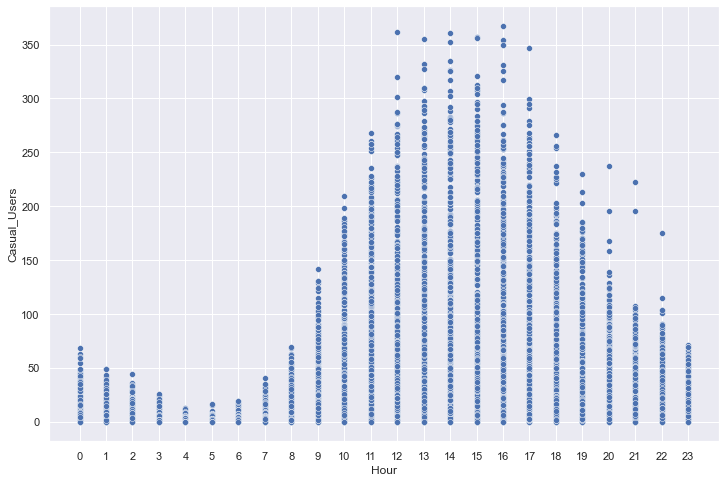

In [ ]:
sns.set(rc = {'figure.figsize':(12,8)})
sns.scatterplot(x = df_hour['Hour'], y = df_hour['Casual_Users'])

tick_values = range(len(df_hour.Hour.unique()))
plt.xticks(tick_values)